<a href="https://colab.research.google.com/github/borbysh/Momentum-QNG/blob/main/min_vertex_cover_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from tqdm import tqdm
import pennylane as qml
from pennylane import GradientDescentOptimizer
import copy


In [2]:
def get_cover_set(val,N):
    cover = set()
    for i in range(N):
        if((val%2) == 1):
            cover.add(N - 1 - i)
        val >>= 1
    return cover
            
def find_minimal_covers(node_count,G):
    min_cover_rank = node_count
    min_covers = []
    min_covers_id = []
    for k in range(1<<node_count):
        cover = get_cover_set(k,node_count)
        is_cover = True
        for u, v in G.edges():
            if u in cover or v in cover:
                continue
            else:
                is_cover = False
                break
        if(is_cover):
            rank = len(cover)
            #print(rank)
            if(rank < min_cover_rank):
                min_cover_rank = rank
                min_covers.clear()
                min_covers.append(cover)
                min_covers_id.clear()
                min_covers_id.append(k)                
            else:
                if( rank == min_cover_rank):
                    min_covers.append(cover)
                    min_covers_id.append(k)
            
    return min_covers, min_covers_id

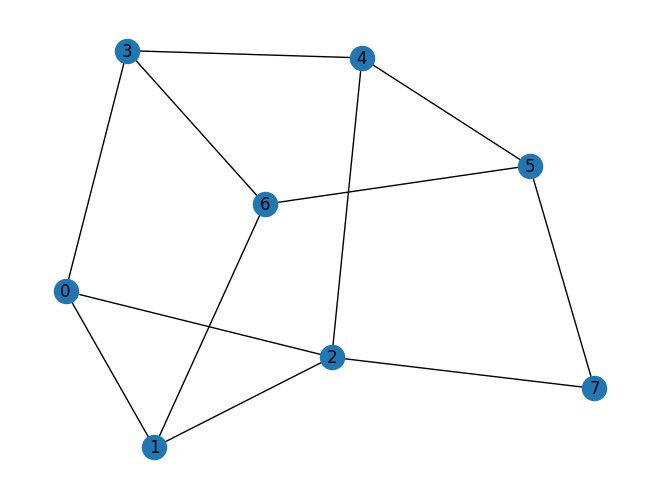

[{1, 2, 3, 5}]
[116]


In [3]:
edges = [(0, 1), (2, 0), (1, 2), (3, 0), (3, 4), (2, 4), (3, 6), (4, 5),
        (1, 6), (5, 7),(7,2),(5,6)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

min_covers,min_covers_id = find_minimal_covers(8,graph)
print(min_covers)
print(min_covers_id)

In [4]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian 0.75 * (Z(0) @ Z(1)) + 0.75 * Z(0) + 0.75 * Z(1) + 0.75 * (Z(0) @ Z(2)) + 0.75 * Z(0) + 0.75 * Z(2) + 0.75 * (Z(0) @ Z(3)) + 0.75 * Z(0) + 0.75 * Z(3) + 0.75 * (Z(1) @ Z(2)) + 0.75 * Z(1) + 0.75 * Z(2) + 0.75 * (Z(1) @ Z(6)) + 0.75 * Z(1) + 0.75 * Z(6) + 0.75 * (Z(2) @ Z(4)) + 0.75 * Z(2) + 0.75 * Z(4) + 0.75 * (Z(2) @ Z(7)) + 0.75 * Z(2) + 0.75 * Z(7) + 0.75 * (Z(3) @ Z(4)) + 0.75 * Z(3) + 0.75 * Z(4) + 0.75 * (Z(3) @ Z(6)) + 0.75 * Z(3) + 0.75 * Z(6) + 0.75 * (Z(4) @ Z(5)) + 0.75 * Z(4) + 0.75 * Z(5) + 0.75 * (Z(6) @ Z(5)) + 0.75 * Z(6) + 0.75 * Z(5) + 0.75 * (Z(5) @ Z(7)) + 0.75 * Z(5) + 0.75 * Z(7) + -1.0 * Z(0) + -1.0 * Z(1) + -1.0 * Z(2) + -1.0 * Z(3) + -1.0 * Z(4) + -1.0 * Z(6) + -1.0 * Z(5) + -1.0 * Z(7)
Mixer Hamiltonian 1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3) + 1 * X(4) + 1 * X(6) + 1 * X(5) + 1 * X(7)


In [5]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [6]:
N = 8 #number of nodes/qubits
wires = range(N)
depth = 6

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [7]:
def plot_opt_data(opt_costs,opt_quality,opt_steps,opt_title,opt_color):
    fig = plt.figure(figsize=(12, 3), layout="compressed")
    axs = fig.subplots(1, 4, sharey=False)
    #fig, axs = plt.subplots(1, 4, sharey=False, tight_layout=False)

    # We can set the number of bins with the *bins* keyword argument.
    n_bins = 10
    quality_bins = [i*0.02 for i in range(50)]
    cost_bins = [-3+i*0.04 for i in range(75)]
    steps_bins = [i for i in range(steps+1)]
    axs[0].hist(opt_costs, bins=cost_bins,color=opt_color)
    axs[1].hist(opt_quality, bins=quality_bins,color=opt_color,label=f"mean={np.array(opt_quality).mean():.4}")
    axs[1].legend()
    axs[2].scatter(opt_costs,opt_quality,color=opt_color)
    axs[3].hist(opt_steps, bins=steps_bins,color=opt_color)
    axs[0].set_xlabel("optimized cost")
    axs[0].set_ylabel("count")
    axs[1].set_xlabel("quality ratio")
    axs[1].set_ylabel("count")
    #axs[0].set_title(opt_title)
    #axs[1].set_title(opt_title)
    axs[2].set_xlabel("optimized cost")
    axs[2].set_ylabel("quality ratio")
    #axs[2].set_xlim(-3,0)
    axs[2].set_ylim(0,1)
    axs[3].set_xlabel("steps")
    axs[3].set_ylabel("count")
    plt.suptitle(opt_title)
    plt.show()

In [8]:
def run_session(optimizer,optimizer_params,init_params_array,steps,cost_tolerance,cost_tolerance_count,device_name):
    dev = qml.device(device_name, wires=wires)
    @qml.qnode(dev)
    def cost_function(params):
        circuit(params)
        return qml.expval(cost_h)

    @qml.qnode(dev)
    def probability_circuit(gamma, alpha):
        circuit([gamma, alpha])
        return qml.probs(wires=wires)
    def quality_ratio(params):
        probs = probability_circuit(params[0], params[1])
        return probs[116]

    def asymmetry_ratio1(params):
        probs = probability_circuit(params[0], params[1])
        return probs[1882]/probs[2922]
    def asymmetry_ratio2(params):
        probs = probability_circuit(params[0], params[1])
        return probs[1898]/probs[2922]
        
    opt_params = []
    opt_steps = []
    opt_costs = []
    opt_quality = []
    opt_asym1 = []
    opt_asym2 = []
    for init_params in tqdm(init_params_array):
        opt = copy.deepcopy(optimizer)
        for id in optimizer_params:
            setattr(opt, id, optimizer_params[id])
        params = init_params
        best_cost = 100
        cost_counter = 0
        for i in range(steps):
            params = opt.step(cost_function, params)
            cur_cost = cost_function(params)
            if(abs(best_cost - cur_cost) < cost_tolerance):
                cost_counter += 1
                if(cost_counter > cost_tolerance_count):
                    break
            else:
                cost_counter = 0
            if(best_cost > cur_cost):
                best_cost = cur_cost
        opt_params.append(params)
        opt_steps.append(i)
        opt_costs.append(cur_cost)
        opt_quality.append(quality_ratio(params))
        #opt_asym1.append(asymmetry_ratio1(params))
        #opt_asym2.append(asymmetry_ratio2(params))
    return (opt_params,opt_steps,opt_costs,opt_quality,opt_asym1,opt_asym2)

In [9]:
stepsizes = [0.225, 0.25]
#stepsizes += [0.05 + 0.05*(x) for x in range(80)]
sessions = [
    {"optimizer" :  qml.MomentumQNGOptimizer(),
     "params" : {"momentum" : 0.9, "approx" : 'block-diag', "lam" : 0.5},
     "params_name" : "$\mathit{"+ chr(961) +"}$=0.9, approx='block-diag', $\mathit{"+ chr(955) + "}$=0.5",
     "stepsizes" : stepsizes,
     "dev" : "lightning.qubit"}
]

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
C:\Users\mbrat\AppData\Local\Temp\ipykernel_5608\3934858662.py:6: SyntaxWarning: invalid escape sequence '\m'
  "params_name" : "$\mathit{"+ chr(961) +"}$=0.9, approx='block-diag', $\mathit{"+ chr(955) + "}$=0.5",
C:\Users\mbrat\AppData\Local\Temp\ipykernel_5608\3934858662.py:6: SyntaxWarning: invalid escape sequence '\m'
  "params_name" : "$\mathit{"+ chr(961) +"}$=0.9, approx='block-diag', $\mathit{"+ chr(955) + "}$=0.5",


In [10]:
init_count = 200
steps = 200

cost_tolerance = 0.01
cost_tolerance_count = 3

seed_value = 340197

init_params_array = []
np.random.seed(seed_value)
for i in range(init_count):
    gam = np.random.random(depth)
    alp = np.random.random(depth)
    init_params_array.append(np.array([gam, alp], requires_grad=True))

In [11]:
from datetime import date
import ipynbname

def save_current_state(num_sessions):
    start_name = ipynbname.name() + "_"
    tail_name = "_depth=" + str(depth)+"_" + str(date.today()) + ".dat"
    with open(start_name + "quality" + tail_name, "w") as file:
        for j in range(len(init_params_array)):
            line = ""
            for i in range(num_sessions):
                for k in range(len(sessions_quality[i])):
                    line += str(sessions_quality[i][k][j]) + " "
            print(j,line,file=file)
    
    with open(start_name + "costs" + tail_name, "w") as file:
        for j in range(len(init_params_array)):
            line = ""
            for i in range(num_sessions):
                for k in range(len(sessions_costs[i])):
                    line += str(sessions_costs[i][k][j]) + " "
            print(j,line,file=file)
    
    with open(start_name + "steps" + tail_name, "w") as file:
        for j in range(len(init_params_array)):
            line = ""
            for i in range(num_sessions):
                for k in range(len(sessions_steps[i])):
                    line += str(sessions_steps[i][k][j]) + " "
            print(j,line,file=file)

    with open(start_name + "params" + tail_name, "w") as file:
        for j in range(len(init_params_array)):
            line = ""
            for i in range(num_sessions):
                for k in range(len(sessions_params[i])):
                    line += str(sessions_params[i][k][j][0]) + " " + str(sessions_params[i][k][j][1]) + " "
            print(j,line,file=file)
    
    with open(start_name + "stepsizes" + tail_name, "w") as file:
        for i in range(num_sessions):
            line = ""
            for k in range(len(sessions_stepsizes[i])):
                line += str(sessions_stepsizes[i][k]) + " "
            print(i,line,file=file)
    return

MomentumQNGOptimizer    stepsize=0.225


100%|██████████| 200/200 [12:25:10<00:00, 223.55s/it]  


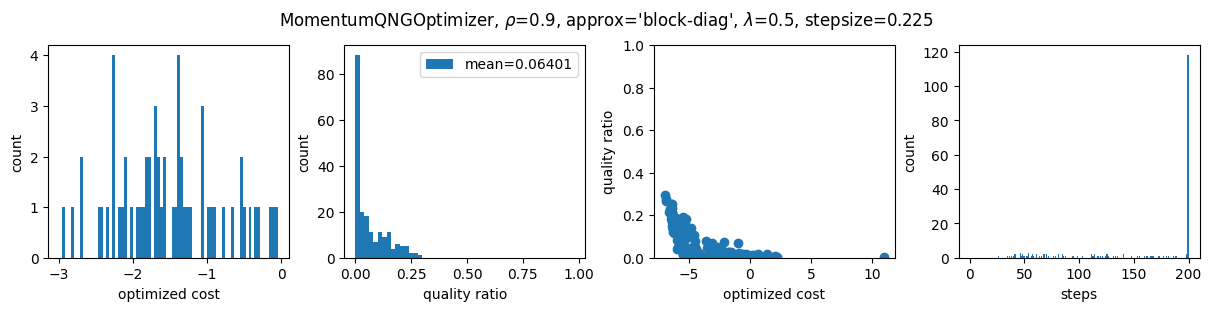

MomentumQNGOptimizer    stepsize=0.25


100%|██████████| 200/200 [15:42:40<00:00, 282.80s/it]  


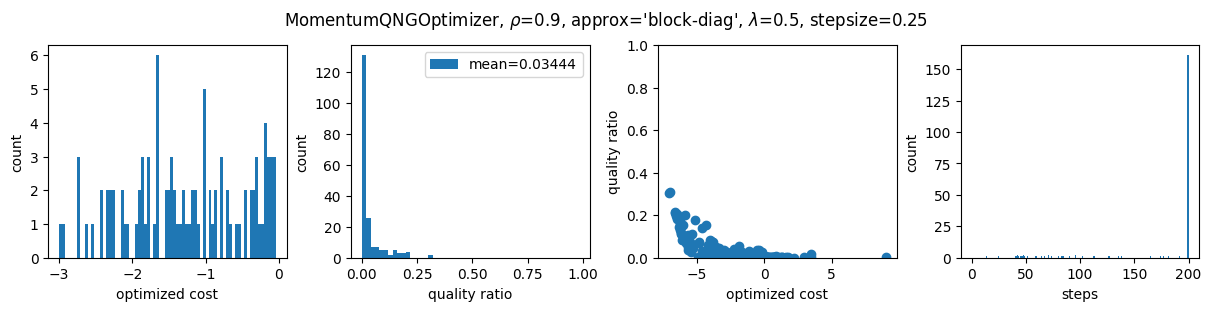

In [12]:
num_sessions = len(sessions)
sessions_params = [None]*num_sessions
sessions_steps = [None]*num_sessions
sessions_costs = [None]*num_sessions
sessions_quality = [None]*num_sessions
sessions_asym1 = [None]*num_sessions
sessions_asym2 = [None]*num_sessions
sessions_stepsizes = [None]*num_sessions
for i,session in enumerate(sessions):
    cur_params = []
    cur_steps = []
    cur_costs = []
    cur_quality = []
    cur_asym1 = []
    cur_asym2 = []
    cur_stepsizes = []
    first_stepsize_mean_quality = 0
    for istepsize,stepsize in enumerate(session["stepsizes"]):
        session_params = copy.deepcopy(session["params"])
        session_params["stepsize"] = stepsize
        title = session["optimizer"].__class__.__name__
        print(title,f"   stepsize={stepsize:.4}")
        if(len(session["params_name"]) > 0):
            title += ", "+ session["params_name"]
        title += ", stepsize=" + str(stepsize)
        (opt_params,opt_steps,opt_costs,opt_quality,opt_asym1,opt_asym2) = run_session(session["optimizer"],session_params,init_params_array,steps,cost_tolerance,cost_tolerance_count,session["dev"])
        plot_opt_data(opt_costs,opt_quality,opt_steps,title,'C'+str(i))
        cur_params.append(opt_params)
        cur_steps.append(opt_steps)
        cur_costs.append(opt_costs)
        cur_quality.append(opt_quality)
#        cur_asym1.append(opt_asym1)
#        cur_asym2.append(opt_asym2).append()
        cur_stepsizes.append(stepsize)

        sessions_params[i] = cur_params
        sessions_steps[i] = cur_steps
        sessions_costs[i] = cur_costs
        sessions_quality[i] = cur_quality
#        sessions_asym1[i] = cur_asym1
#        sessions_asym2[i] = cur_asym2 
        sessions_stepsizes[i] = cur_stepsizes
        
        save_current_state(i+1)
        if(istepsize == 0):
            first_stepsize_mean_quality = np.array(opt_quality).mean()
        if(np.array(opt_quality).mean() < first_stepsize_mean_quality/2):
            break
    #sessions_params.append(cur_params)
    #sessions_steps.append(cur_steps)
    #sessions_costs.append(cur_costs)
    #essions_quality.append(cur_quality)
    #sessions_asym1.append(cur_asym1)
    #essions_asym2.append(cur_asym2)